[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [ ]:
pip install river

# Regression

In [58]:
from river import stream
from river.datasets import base


class SolarFlare(base.FileDataset):
    def __init__(self):
        super().__init__(
            n_samples=1066,
            n_features=10,
            n_outputs=1,
            task=base.MO_REG,
            filename="solar-flare.csv.zip",
        )

    def __iter__(self):
        return stream.iter_csv(
            self.path,
            target="m-class-flares",
            converters={
                "zurich-class": str,
                "largest-spot-size": str,
                "spot-distribution": str,
                "activity": int,
                "evolution": int,
                "previous-24h-flare-activity": int,
                "hist-complex": int,
                "hist-complex-this-pass": int,
                "area": int,
                "largest-spot-area": int,
                "c-class-flares": int,
                "m-class-flares": int,
                "x-class-flares": int,
            },
        )
    

In [59]:
from pprint import pprint
from river import datasets

for x, y in SolarFlare():
    pprint(x)
    pprint(y)
    break

{'activity': 1,
 'area': 1,
 'c-class-flares': 0,
 'evolution': 3,
 'hist-complex': 1,
 'hist-complex-this-pass': 1,
 'largest-spot-area': 1,
 'largest-spot-size': 'A',
 'previous-24h-flare-activity': 1,
 'spot-distribution': 'X',
 'x-class-flares': 0,
 'zurich-class': 'H'}
0


In [70]:
import numbers
from river import compose
from river import datasets
from river import evaluate
from river import linear_model
from river import metrics
from river import preprocessing
from river import tree

dataset = SolarFlare()
num = compose.SelectType(numbers.Number) | preprocessing.MinMaxScaler()
cat = compose.SelectType(str) | preprocessing.OneHotEncoder(sparse=False)
model = tree.HoeffdingTreeRegressor()
pipeline = (num + cat) | model
metric = metrics.MAE()
#evaluate.progressive_val_score(dataset, pipeline, metric)

In [71]:
errors = []
for x, y in SolarFlare():
    y_pred = pipeline.predict_one(x)
    metric = metric.update(y, y_pred)
    errors.append(metric.get())
    pipeline = pipeline.learn_one(x, y)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(
    errors,
    "ro",
    alpha=0.6,
    markersize=2,
    linewidth=4
)

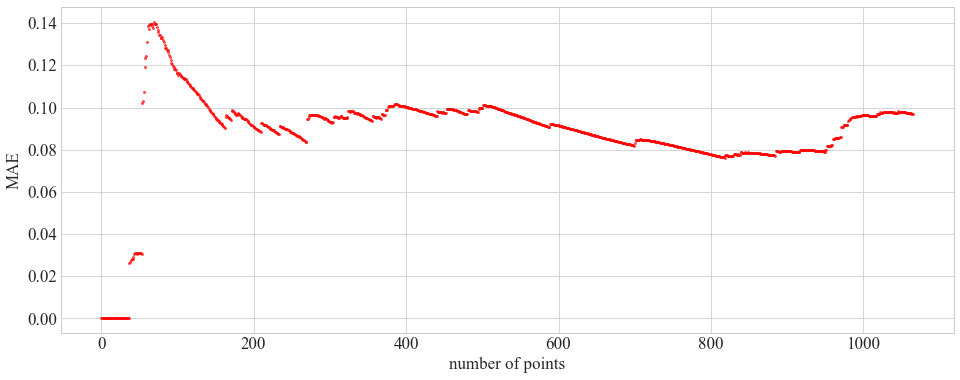

In [85]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(
    errors,
    "ro",
    alpha=0.6,
    markersize=2,
    linewidth=4
)
ax.set_xlabel("number of points")
ax.set_ylabel("MAE");

# Adaptive Models on a Concept Drift Data Stream

In [318]:
from river import (
    synth, ensemble, tree,
    evaluate, metrics
)

models = [
    tree.HoeffdingTreeRegressor(),
    tree.HoeffdingAdaptiveTreeRegressor(),
    ensemble.AdaptiveRandomForestRegressor(seed=42),
]

results = {}
for model in models:
    metric = metrics.MSE()
    errors = []
    dataset = synth.ConceptDriftStream(
        seed=42, position=500, width=40
    ).take(1000)    
    for i, (x, y) in enumerate(dataset):
        y_pred = model.predict_one(x)
        metric = metric.update(y, y_pred)
        model = model.learn_one(x, y)
        if (i % 100) == 0:
            errors.append(dict(step=i, error=metric.get()))
    results[str(model.__class__).split(".")[-1][:-2]] = errors

In [ ]:
results

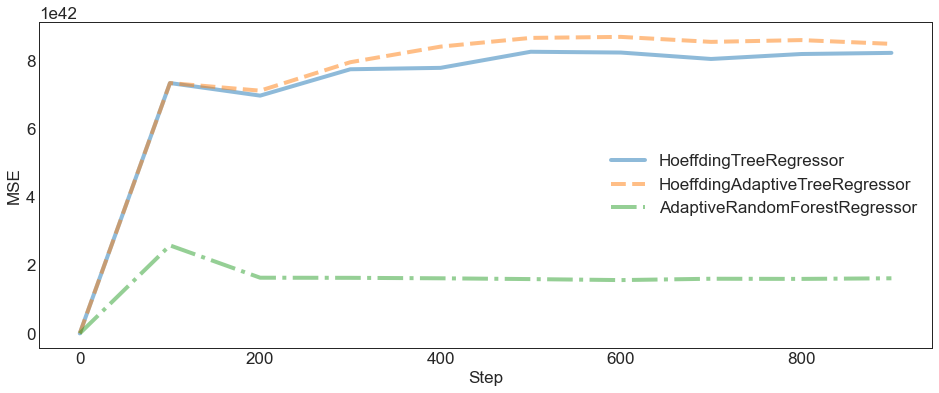

In [316]:
plt.figure(figsize=(16, 6))
styles = ["-","--","-.",":"]
markers = [
    '.', ',', 'o', 'v', '^', '<', '>',
    '1', '2', '3', '4', '8', 's', 'p',
    '*', 'h', 'H', '+', 'x', 'D', 'd',
    '|', '_', 'P', 'X', 0, 1, 2, 3, 4,
    5, 6, 7, 8, 9, 10, 11
]

for i, (model, errors) in enumerate(results.items()):
    df = pd.DataFrame(errors)
    sns.lineplot(
        data=df,
        x="step",
        y="error",
        linestyle=styles[i%len(styles)],
        alpha=0.5,
        markersize=22,
        markers=markers[i%len(markers)],        
        label=model,
        linewidth=4
    )
    
plt.ylabel("MSE")
plt.xlabel("Step")
sns.set_style("ticks")